# Couette flow PDE

Diffrax can also be used to solve some PDEs.

(Specifically, the scope of Diffrax is "any numerical method which iterates over timesteps". This means that e.g. semidiscretised evolution equations are in-scope, but e.g. finite volume methods for elliptic equations are out-of-scope.)

---

In this example, we solve the Couette flow equation

$$ \rho \frac{\partial u}{\partial t}(t, y) =  \mu \Delta u(t, y) \qquad\text{in}\qquad t \in [0, 2500], y \in [0, 1]$$

subject to the initial condition

$$ u(0, y) =  I_{y=1}, $$

and Dirichlet boundary conditions

$$ u(t, 0) = 0,\qquad u(t, 1) = 1. $$

---

We spatially discretise $y \in [0, 1]$ into points $0 = y_0 < y_1 < \cdots < y_{n-1} = 1$, with equal spacing $\delta y = y_{i+1} - y_i$. The solution is then discretised into $u(t, y_i) \approx u_i(t)$, and the Laplacian discretised into $\Delta u(t,y_i) \approx \frac{u_{i+1}(t) - 2u_{i}(t) + u_{i-1}(t)}{\delta y^2}$.

In doing so we reduce to a system of ODEs

$$ \frac{\mathrm{d}u_i}{\mathrm{d}t}(t) = (1 - u_i(t)) \frac{u_{i+1}(t) - 2u_{i}(t) + u_{i-1}(t)}{\delta y^2} \qquad\text{for}\qquad i \in \{1, ..., n-2\},$$

subject to the initial condition

$$ u_i(0) = I_{y=1}, $$

for which the Dirichlet boundary conditions become

$$ \frac{\mathrm{d}u_0}{\mathrm{d}t}(t) = 0,\qquad \frac{\mathrm{d}u_{n-1}}{\mathrm{d}t}(t) = 0. $$

In [1]:
from typing import Callable

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping
import brainunit as u
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D
jax.config.update("jax_enable_x64", True)

In [2]:
# Represents the interval [x0, x_final] discretised into n equally-spaced points.
class SpatialDiscretisation(eqx.Module):
    x0: float = eqx.field(static=True)
    x_final: float = eqx.field(static=True)
    vals: Float[Array, "n"]

    @classmethod
    def discretise_fn(cls, x0: float, x_final: float, n: int, fn: Callable):
        if n < 2:
            raise ValueError("Must discretise [x0, x_final] into at least two points")
        vals = jax.vmap(fn)(u.math.linspace(x0,x_final,n))
        return cls(x0, x_final, vals)

    @property
    def δx(self):
        return (self.x_final - self.x0) / (len(self.vals) - 1)

    def binop(self, other, fn):
        if isinstance(other, SpatialDiscretisation):
            if self.x0 != other.x0 or self.x_final != other.x_final:
                raise ValueError("Mismatched spatial discretisations")
            other = other.vals
        return SpatialDiscretisation(self.x0, self.x_final, fn(self.vals, other))

    def __add__(self, other):
        return self.binop(other, lambda x, y: x + y)

    def __mul__(self, other):
        return self.binop(other, lambda x, y: x * y)

    def __radd__(self, other):
        return self.binop(other, lambda x, y: y + x)

    def __rmul__(self, other):
        return self.binop(other, lambda x, y: y * x)

    def __sub__(self, other):
        return self.binop(other, lambda x, y: x - y)

    def __rsub__(self, other):
        return self.binop(other, lambda x, y: y - x)
    
    def __truediv__(self, other):
        return self.binop(other, lambda x, y: x / y)


def laplacian(y: SpatialDiscretisation) -> SpatialDiscretisation:
    y_next = u.math.roll(y.vals, shift=1)
    y_prev = u.math.roll(y.vals, shift=-1)
        
    Δy = (y_next - 2 * y.vals + y_prev) / (y.δx**2)

    # Dirichlet boundary condition
    Δy = Δy.at[0].set(0 /(u.meter * u.second))
    Δy = Δy.at[-1].set(0/(u.meter * u.second))
    return SpatialDiscretisation(y.x0, y.x_final, Δy)

First let's try solving this semidiscretisation directly, as a system of ODEs.

In [3]:
# Problem

mu = 1 * u.kilogram / (u.meter * u.second)
rho = 1 * u.kilogram / u.meter3

def vector_field(t, y, args):
    return laplacian(y) * 2e-4 * mu / rho


term = diffrax.ODETerm(vector_field)

def ic(x):
    return u.math.where(x == 1 * u.meter, 1.0 * u.meter/u.second, 0.0 * u.meter/u.second)


# Spatial discretisation
x0 = 0 * u.meter
x_final = 1 * u.meter
n = 21
y0 = SpatialDiscretisation.discretise_fn(x0, x_final, n, ic)

# Temporal discretisation
t0 = 0 * u.second
t_final = 2500 * u.second
δt = 12.5 * u.second
saveat = diffrax.SaveAt(ts=u.math.linspace(t0, t_final, 21))

# Tolerances
rtol = 1e-10
atol = 1e-10
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol #, dtmax=12.5 * u.second
)


/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_31983/3586489615.py:12: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return cls(x0, x_final, vals)


In [4]:
solver = diffrax.Tsit5()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    δt,
    y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_31983/3586489615.py:56: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return SpatialDiscretisation(y.x0, y.x_final, Δy)
/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_31983/3586489615.py:23: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return SpatialDiscretisation(self.x0, self.x_final, fn(self.vals, other))
/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_31983/3586489615.py:56: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return SpatialDiscretisation(y.x0, y.x_final, Δy)
/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_31983/3586489615.py:23: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return

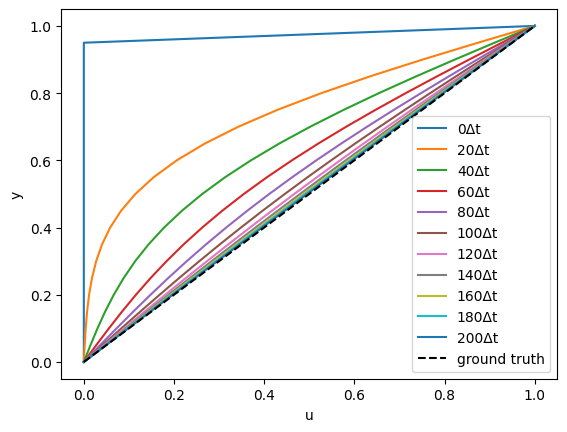

In [5]:
indices = np.arange(0, sol.ys.vals.shape[0], 2)  

vector = np.linspace(0, 1, 21)

for idx in indices:
    plt.plot(sol.ys.vals[idx, :], vector, label=f"{idx*10}Δt")

plt.plot(vector, vector, label="ground truth", linestyle='--', color='k') 

plt.xlabel("u")
plt.ylabel("y")
plt.legend()
plt.show()


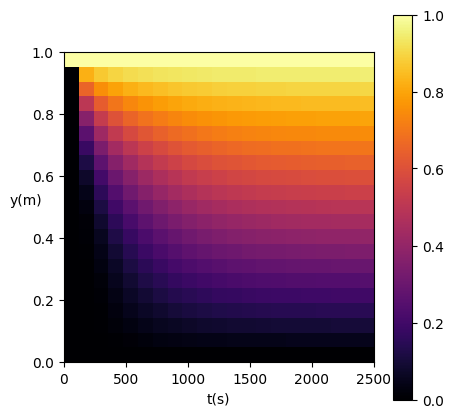

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(
    sol.ys.vals.to_decimal(u.meter/u.second).T,  
    origin="lower",
    extent=(t0.to_decimal(u.second), t_final.to_decimal(u.second), x0.to_decimal(u.meter), x_final.to_decimal(u.meter)),  
    aspect=(t_final.to_decimal(u.second) - t0.to_decimal(u.second)) / (x_final.to_decimal(u.meter) - x0.to_decimal(u.meter)),  
    cmap="inferno",
)
plt.xlabel("t(s)")
plt.ylabel("y(m)", rotation=0) 
plt.clim(0, 1)
plt.colorbar()
plt.show()

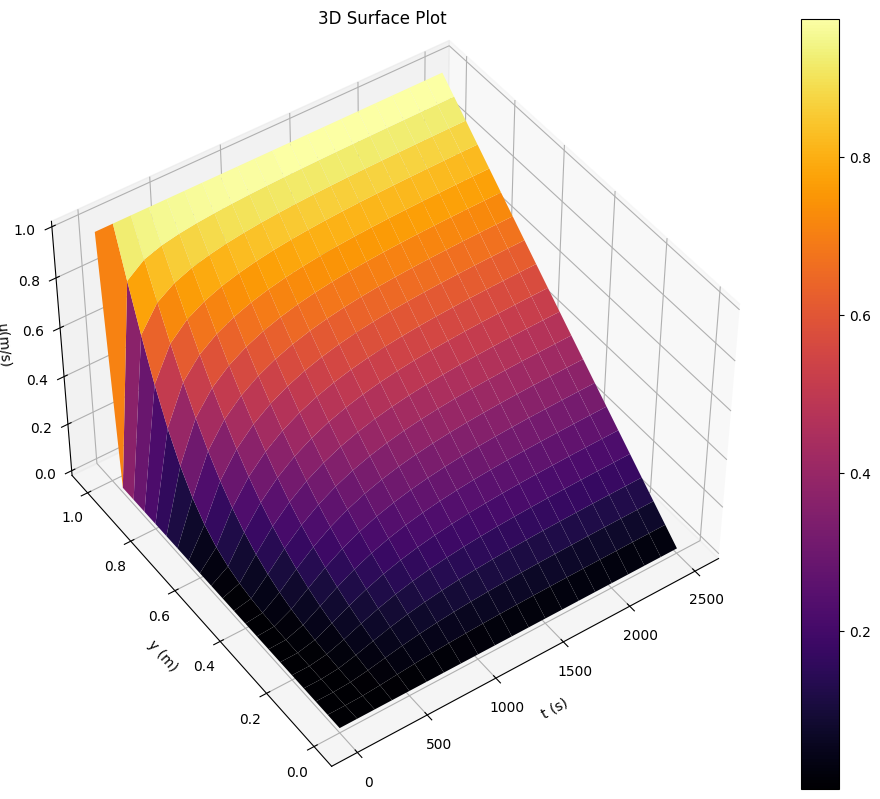

In [7]:
ys_np = sol.ys.vals.to_decimal(u.meter / u.second).T  

t_vals = np.linspace(t0.to_decimal(u.second), t_final.to_decimal(u.second), ys_np.shape[1])
x_vals = np.linspace(x0.to_decimal(u.meter), x_final.to_decimal(u.meter), ys_np.shape[0])

T, X = np.meshgrid(t_vals, x_vals)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T, X, ys_np, cmap='inferno', edgecolor='none')

ax.set_xlabel('t (s)')
ax.set_ylabel('y (m)')
ax.set_zlabel('u(m/s)')
ax.set_title('3D Surface Plot')


fig.colorbar(surf)
ax.view_init(elev=45, azim=235)

plt.show()
